In [31]:
# Cell 2: 导入
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ase.io import read
from pathlib import Path
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyBboxPatch, Circle

In [32]:
# Cell 3: 读 CIF
# 改成你的 cif 路径
cif_path = "sub100_film100_termAs_P4-mmm_1_P_P4-mmm_1_cand0_film_bulk.cif"

assert os.path.exists(cif_path), f"File not found: {cif_path}"
atoms = read(cif_path)

print("Loaded:", cif_path)
print("Number of atoms:", len(atoms))
print("Cell (Å):\n", atoms.cell.array)
print("Elements:", sorted(set(atoms.get_chemical_symbols())))

Loaded: sub100_film100_termAs_P4-mmm_1_P_P4-mmm_1_cand0_film_bulk.cif
Number of atoms: 252
Cell (Å):
 [[11.5003642   0.          0.        ]
 [ 0.         11.5003642   0.        ]
 [ 0.          0.         56.79846868]]
Elements: ['Ga', 'P']


In [33]:
# Cell 4: 构建全连接图（complete graph）
def build_fully_connected_graph(atoms, max_atoms=60, seed=0):
    """
    返回: (atoms_sub, G)
    - atoms_sub: 用于可视化的子结构（如果原子太多会截断）
    - G: 全连接 NetworkX 图
    """
    n = len(atoms)
    if n > max_atoms:
        rng = np.random.default_rng(seed)
        idx = np.sort(rng.choice(n, size=max_atoms, replace=False))
        atoms_sub = atoms[idx]
        print(f"[warn] atoms={n} too large for full visualization, sampled {max_atoms} atoms.")
    else:
        atoms_sub = atoms

    n_sub = len(atoms_sub)
    G = nx.complete_graph(n_sub)

    symbols = atoms_sub.get_chemical_symbols()
    pos = atoms_sub.get_positions()

    for i in range(n_sub):
        G.nodes[i]["element"] = symbols[i]
        G.nodes[i]["pos"] = pos[i]

    # 边属性（可选）：距离
    for i, j in G.edges():
        dij = float(np.linalg.norm(pos[i] - pos[j]))
        G.edges[i, j]["dist"] = dij

    return atoms_sub, G

atoms_sub, G = build_fully_connected_graph(atoms, max_atoms=60, seed=0)
print("Sub-atoms:", len(atoms_sub))
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

[warn] atoms=252 too large for full visualization, sampled 60 atoms.
Sub-atoms: 60
Nodes: 60 Edges: 1770


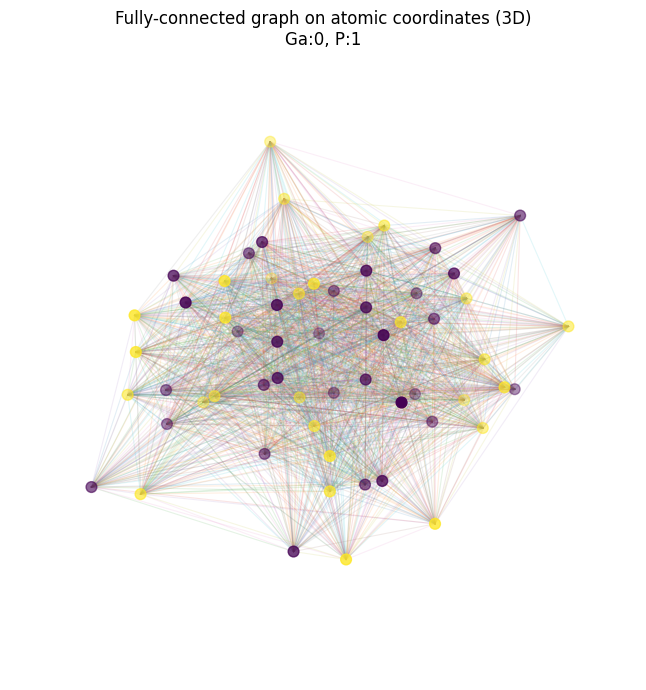

In [34]:
# Cell 5: 3D 几何可视化（真实坐标 + 全连接边）
def plot_geometry_complete_graph(atoms_sub, G, point_size=60, edge_alpha=0.12, edge_lw=0.8):
    pos = np.array([G.nodes[i]["pos"] for i in G.nodes()])
    elems = [G.nodes[i]["element"] for i in G.nodes()]

    # 为不同元素分配颜色（matplotlib 自动循环，不指定固定颜色）
    uniq = sorted(set(elems))
    elem_to_id = {e: k for k, e in enumerate(uniq)}
    cvals = np.array([elem_to_id[e] for e in elems], dtype=float)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    # 边：全连接线段
    for i, j in G.edges():
        p1, p2 = pos[i], pos[j]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                linewidth=edge_lw, alpha=edge_alpha)

    # 点：原子
    sc = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
                    s=point_size, c=cvals)

    # 轻量图例：元素 -> 编号
    legend_text = ", ".join([f"{e}:{elem_to_id[e]}" for e in uniq])
    ax.set_title(f"Fully-connected graph on atomic coordinates (3D)\n{legend_text}")

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

plot_geometry_complete_graph(atoms_sub, G)

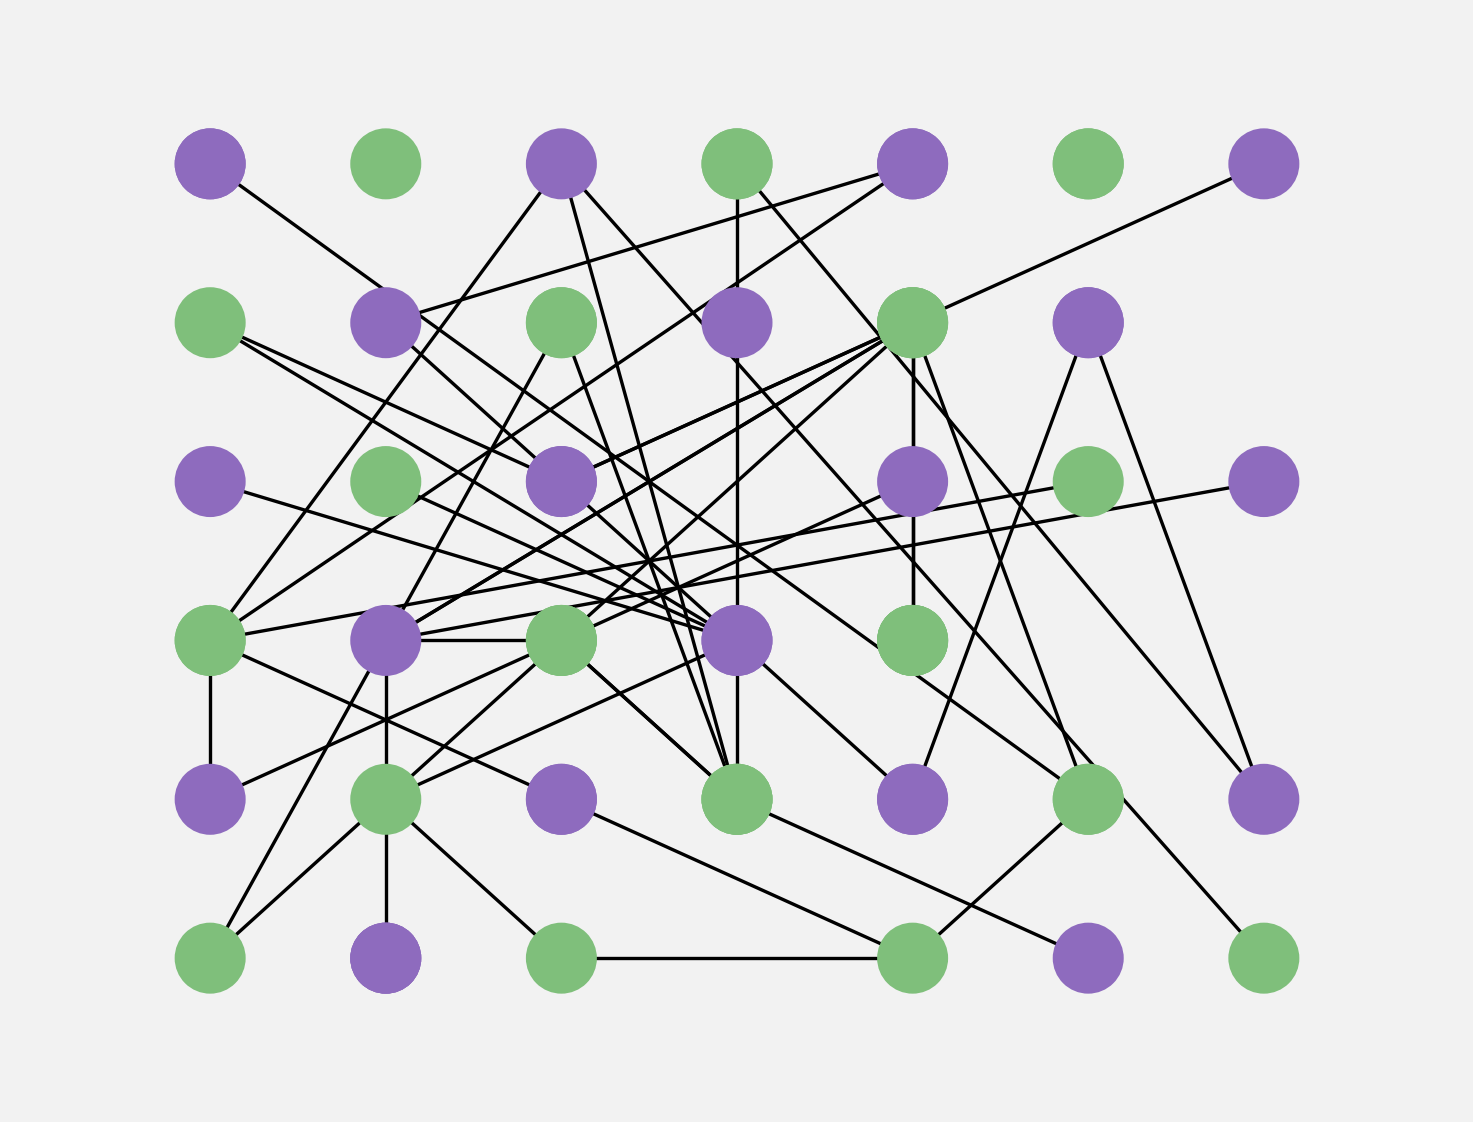

In [35]:
# Cell 6: NetworkX “图结构”可视化（spring layout）
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_complete_graph_pure_color(
    atoms_sub,
    G,
    projection="xy",

    node_size=520,     # 节点大一些，视觉主体
    edge_lw=1.2,       # 线细而清晰
    max_edges=45,

    seed=0,
    out_file=None,
    show=True,
):
    rng = np.random.default_rng(seed)

    GREEN  = "#7FBF7B"
    PURPLE = "#8E6BBE"
    EDGE   = "#000000"
    BG     = "#F2F2F2"

    pos3 = np.array([G.nodes[i]["pos"] for i in G.nodes()])
    if projection == "xy":
        pos2 = pos3[:, [0, 1]]
    elif projection == "xz":
        pos2 = pos3[:, [0, 2]]
    elif projection == "yz":
        pos2 = pos3[:, [1, 2]]

    pmin, pmax = pos2.min(0), pos2.max(0)
    span = np.maximum(pmax - pmin, 1e-9)
    posn = (pos2 - pmin) / span
    pad = 0.08
    posn = posn * (1 - 2 * pad) + pad

    elems = [G.nodes[i].get("element", "X") for i in G.nodes()]
    uniq = sorted(set(elems))
    green_elem = uniq[0] if uniq else "X"
    node_colors = [GREEN if e == green_elem else PURPLE for e in elems]

    edges = list(G.edges())
    if len(edges) > max_edges:
        idx = rng.choice(len(edges), size=max_edges, replace=False)
        edges = [edges[i] for i in idx]

    segs = [[posn[i], posn[j]] for i, j in edges]

    fig, ax = plt.subplots(figsize=(6.8, 5.2), dpi=220)
    fig.patch.set_facecolor(BG)
    ax.set_facecolor(BG)

    lc = LineCollection(segs, colors=EDGE,
                        linewidths=edge_lw, alpha=1.0, zorder=1)
    ax.add_collection(lc)

    ax.scatter(
        posn[:, 0], posn[:, 1],
        s=node_size,
        c=node_colors,
        edgecolors="none",
        zorder=3,
        clip_on=False,
    )

    margin = 0.07
    ax.set_xlim(-margin, 1 + margin)
    ax.set_ylim(-margin, 1 + margin)
    ax.axis("off")
    fig.tight_layout()

    if out_file is not None:
        fig.savefig(out_file, bbox_inches="tight",
                    facecolor=fig.get_facecolor())

    if show:
        plt.show()

    return fig, ax

fig, ax = plot_complete_graph_pure_color(
    atoms_sub, G,
    node_size=540,
    max_edges=40,
    edge_lw=1.1,
    out_file=Path(cif_path).with_suffix(".pdf"),
)